### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO


import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Visualize running behavior for all rats and tally lap #s by hand

In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
# sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
sessions = subjects.remaze_realign_sess()[1:]  # RatSDay2NSD does not have remaze position info

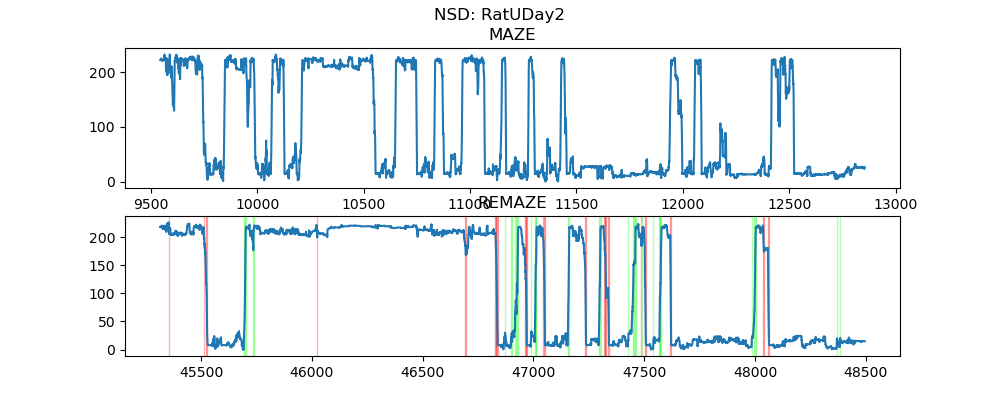

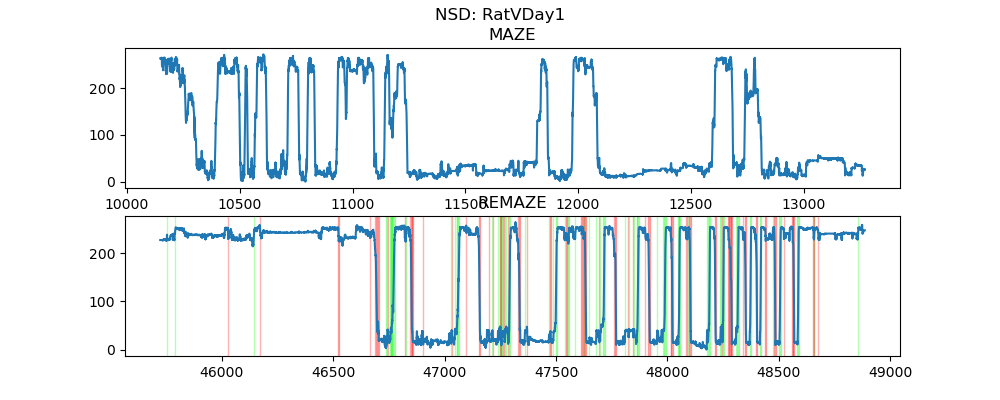

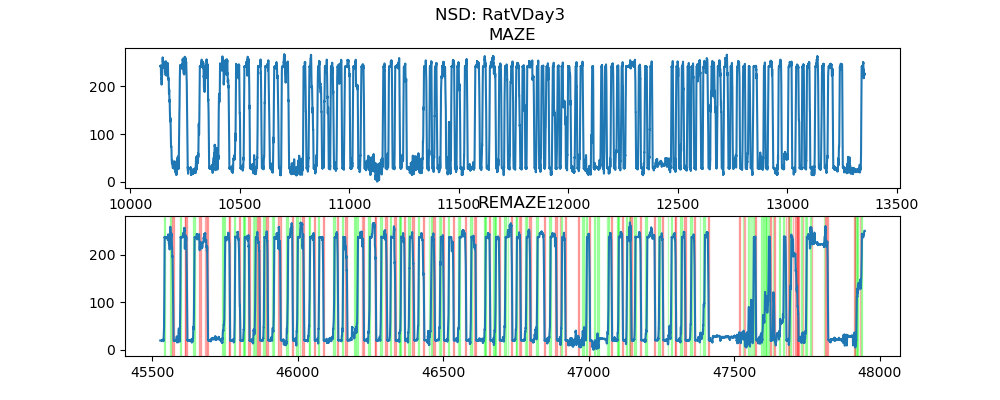

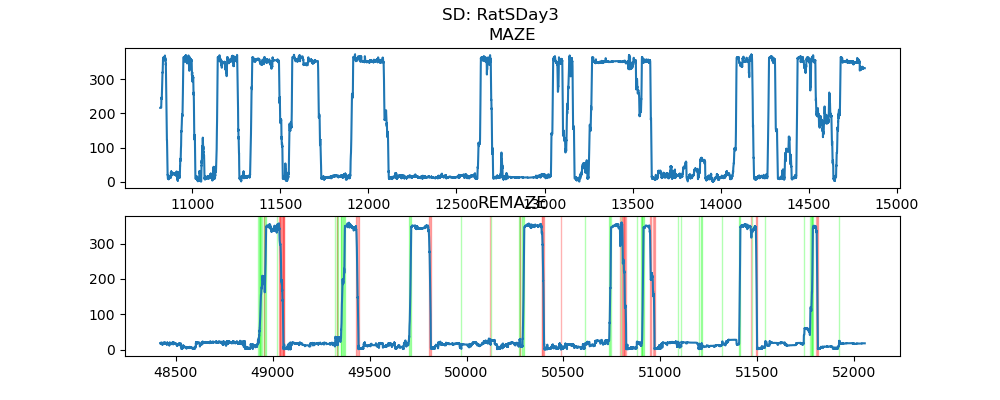

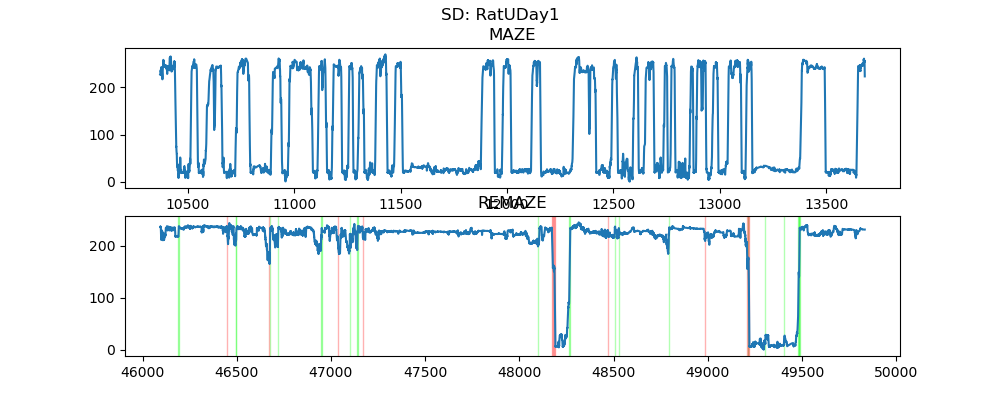

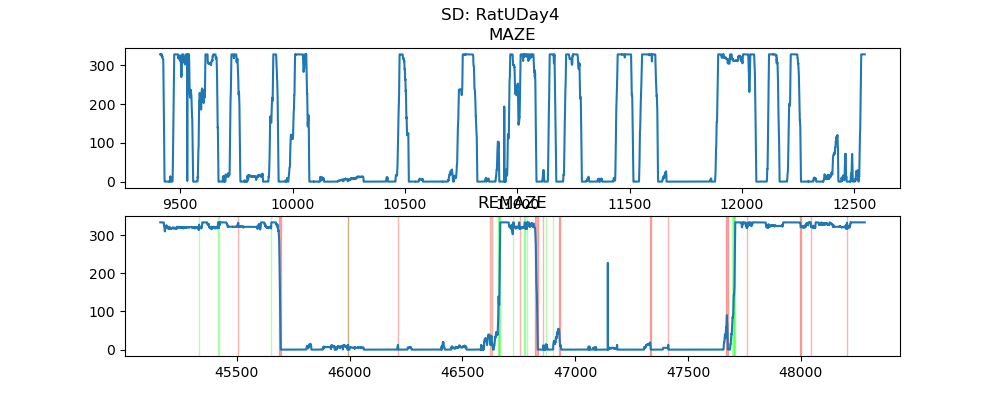

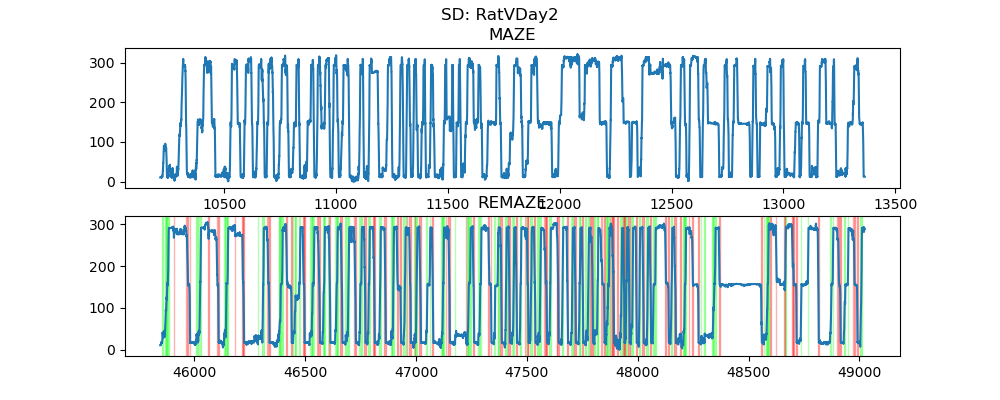

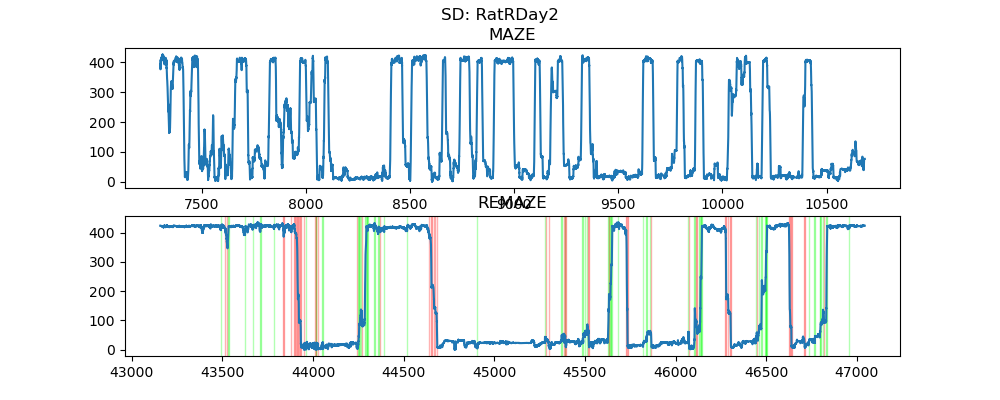

In [3]:
%matplotlib widget
for sess in sessions:
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    fig.suptitle(f"{sess.tag}: {sess.name}")
    ax[0].plot(sess.maze.time, sess.maze.x)
    ax[0].set_title("MAZE")
    ax[1].plot(sess.remaze.time, sess.remaze.x)
    ax[1].set_title("REMAZE")
    for col, dir in zip([[0, 1, 0, 0.3], [1, 0, 0, 0.3]], ["up", "down"]):
        for start, stop in zip(sess.remaze_run[dir].starts, sess.remaze_run[dir].stops):
            ax[1].axvspan(start, stop, color=col)

### Phase precession plots
Use to vet appropriate thresholds for generating place fields and for general place field quality control.

TAKE HOME: 3 Hz FR threshold, 10 cm/s speed threshold, and 5 cm bins work well and produce great phase precession:  
`kw = dict(frate_thresh=3, grid_bin=5, speed_thresh=10)`

#### Plot out raw signal, speed, and theta power together to check theta epoch detection
Bumps in speed should roughly align with increases in theta, though this is better for some rats (RatV) and worse for others (RatU)

Best channel for theta: [0]
22477 epochs remaining with durations within (0.25,None)


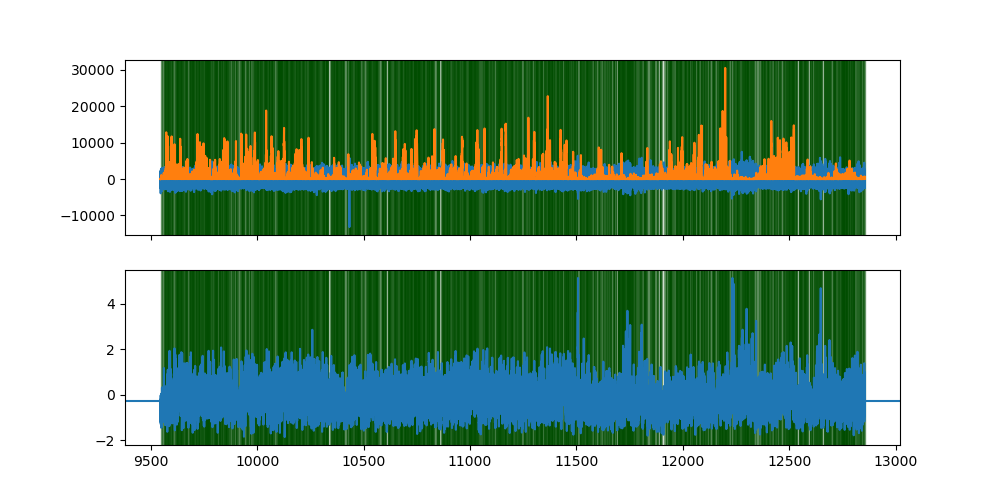

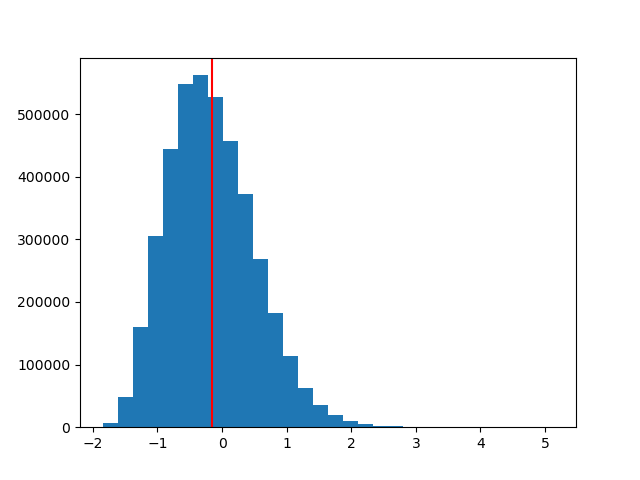

In [4]:
# Code for checking theta epoch detection
from neuropy.plotting.signals import plot_signal_w_epochs
from neuropy.core.signal import Signal

# Specify session to plot
sess = sessions[0]  # 0 is RatUDay2NSD
t_shift = 0

# Specify theta params
theta_params = {'freq_band': (5, 12),
                'thresh': (0, None),
                'edge_cutoff': -0.25,
                'mindur': 0.25,
                'maxdur': None,
                'sigma': 0.125}

# Get EEG signal from best theta channel
eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
theta_sig = sess.thetachan_eeg.get_signal()

# Get theta power epochs
theta_epochs, theta_power = detect_theta_epochs(theta_sig, ignore_epochs=sess.artifact, return_power=True, **theta_params)

_, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
plot_signal_w_epochs(theta_sig.time_slice(t_start=sess.maze.t_start, t_stop=sess.maze.t_stop), 
                          channel=0, epochs=theta_epochs.time_slice(t_start=sess.maze.t_start, t_stop=sess.maze.t_stop), ax=ax[0])
pos_smooth = sess.maze.get_smoothed(0.1)
if t_shift != 0:
    pos_smooth.t_start = pos_smooth.t_start + t_shift
ax[0].plot(pos_smooth.time, pos_smooth.speed * 200)
# ax[0].plot(sess.maze.time, sess.maze.speed * 100)  # This is a Position class

power_bool = (theta_sig.time > sess.maze.t_start) & (theta_sig.time < sess.maze.t_stop)
power_sig = Signal(theta_power[power_bool], theta_sig.sampling_rate, t_start=sess.maze.t_start)
plot_signal_w_epochs(power_sig, channel=0, epochs=theta_epochs.time_slice(t_start=sess.maze.t_start, t_stop=sess.maze.t_stop), ax=ax[1])
ax[1].axhline(-0.25)
# ax[1].plot(theta_sig.time[power_bool], theta_power[power_bool])

_, ax = plt.subplots()
ax.hist(theta_power[power_bool], bins=30)
ax.axvline(theta_power[power_bool].mean(), color='r')

Loading previously saved theta_epochs at /data/Clustering/sessions/RatU/RatUDay2NSD/RatU_Day2NSD_2021-07-24_08-16-38.theta_epochs.npy
Note: speed_thresh is ignored when epochs is provided
eeg file min = 808.309, last spike time = 808.309


interactive(children=(IntSlider(value=0, description='Cell ID:', max=108), Output()), _dom_classes=('widget-in…

Note: speed_thresh is ignored when epochs is provided
eeg file min = 808.309, last spike time = 808.309


interactive(children=(IntSlider(value=0, description='Cell ID:', max=101), Output()), _dom_classes=('widget-in…

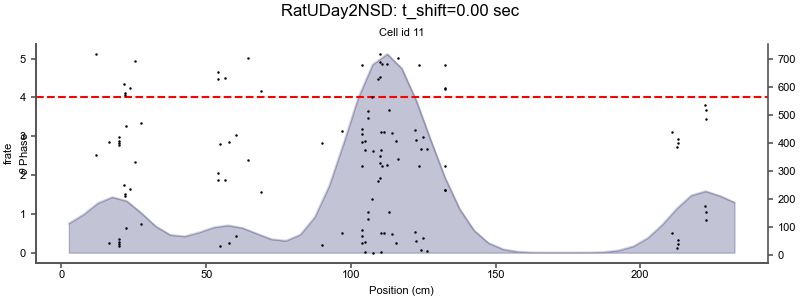

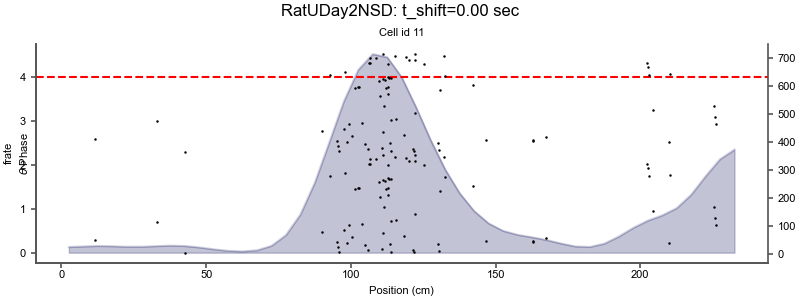

In [6]:
rat_id = 0
sess = sessions[rat_id]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")

# Placefield parameters
kw = dict(frate_thresh=3, grid_bin=5, speed_thresh=10)  # Produces good phase precession for plots...

# Theta phase precession parameters
theta_thresh = True
theta_params = {'freq_band': (5, 12),
                'thresh': (0, None),
                'edge_cutoff': -0.25,
                'mindur': 0.25,
                'maxdur': None,
                'sigma': 0.125}

# Get EEG signal from best theta channel
eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
theta_sig = sess.thetachan_eeg.get_signal()

# Get theta power epochs
if theta_thresh:
    try:
        # assert False
        print(f"Loading previously saved theta_epochs at {sess.filePrefix.with_suffix('.theta_epochs.npy')}")
        theta_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".theta_epochs.npy"))
        assert np.all([theta_epochs.metadata['params'][param] == theta_params[param] for param in theta_params.keys()])
    except (FileNotFoundError, AssertionError, KeyError):  # Run if no previously saved file or if previous run was with different parameters
        theta_epochs = detect_theta_epochs(theta_sig, ignore_epochs=sess.artifact, **theta_params)
        theta_epochs.save(sess.filePrefix.with_suffix(".theta_epochs.npy"))

for run_dir in ["up", "down"]:
    # assert False, "need to shift maze_run times if re-aligned speed via theta is used"
    maze_run = sess.maze_run[run_dir]
    run_bool = sess.maze.speed > kw["speed_thresh"]
    run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
    maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)
    if theta_thresh:
        maze_run_thresh = maze_run_thresh.intersection(theta_epochs, res=1/sess.maze.sampling_rate)
    
    pfmaze = Pf1D(neurons, position=pos_use, epochs=maze_run_thresh, sigma_pos=0.1, **kw)
    
    # pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    
    eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
    sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
    print(f"eeg file min = {sess.thetachan_eeg.n_frames / 1250 / 60:.3f}, last spike time = {neurons.get_all_spikes()[-1] / 60:.3f}")
    
    pfmaze.estimate_theta_phases(theta_sig.time_slice(t_start=pfmaze.t_start, t_stop=pfmaze.t_stop))
    
    ax = pfmaze.plot_with_phase(sigma=2, subplots=None, normalize=False, plot_thresh=4)
    ax.figure.suptitle(f"{sess.name}{sess.tag}: t_shift={t_shift:.2f} sec")

In [ ]:
# # Code for checking speed threshold
# _, ax = plt.subplots(3, 1, sharex=True)
# ax[0].plot(sess.maze.time, sess.maze.x, '.-', markersize=3)
# ax[1].plot(sess.maze.time, sess.maze.speed)
# speed_thresh_bool = sess.maze.speed > 10
# ax[1].plot(sess.maze.time[speed_thresh_bool], sess.maze.speed[speed_thresh_bool], 'r.', markersize=3)
# speed_thresh_bool2 = pos_smooth.speed > 10
# ax[2].plot(pos_smooth.time, pos_smooth.speed)
# ax[2].plot(pos_smooth.time[speed_thresh_bool2], pos_smooth.speed[speed_thresh_bool2], 'r.', markersize=3)

### First, that re-aligned position data produces good phase precession.  
Below shows that just re-aligning the position data doesn't work because the run epochs times are still offset. The end result is some weird looking line of spike that sometimes pops up at the ends of the track

Re-aliging the position and epoch data fixes it with good looking phase precession!

Check out cell 135 from RatUDay1SD (`subjects.remaze_sess()[5]` or `sessions[4]`)

#### Todo: consider using phase precession as a metric of field quality

Loading previously saved theta_epochs at /data/Clustering/sessions/RatU/RatUDay2NSD/RatU_Day2NSD_2021-07-24_08-16-38.theta_epochs.npy
Note: speed_thresh is ignored when epochs is provided
eeg file min = 808.309, last spike time = 808.309


interactive(children=(IntSlider(value=0, description='Cell ID:', max=99), Output()), _dom_classes=('widget-int…

Note: speed_thresh is ignored when epochs is provided
eeg file min = 808.309, last spike time = 808.309


interactive(children=(IntSlider(value=0, description='Cell ID:', max=99), Output()), _dom_classes=('widget-int…

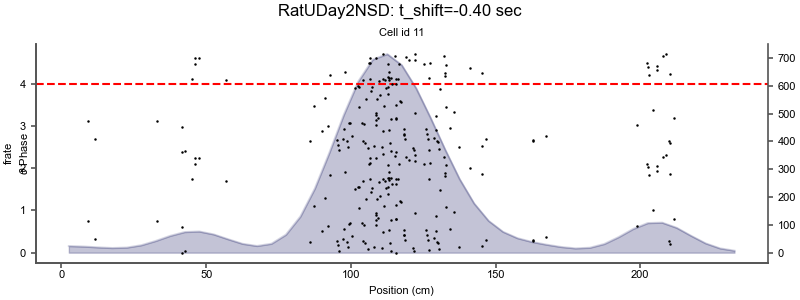

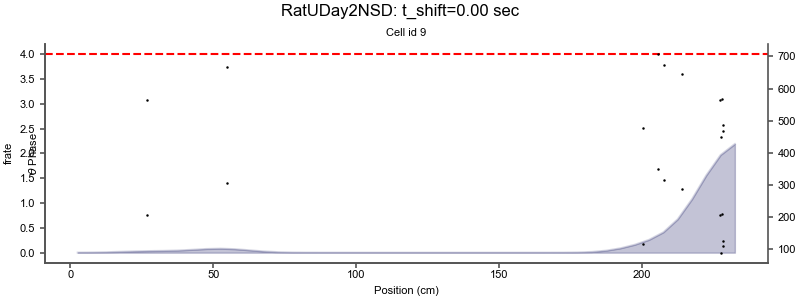

In [14]:
# Load in test session
rat_id = 0
sess = sessions[rat_id]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")

# Placefield parameters
kw = dict(frate_thresh=3, grid_bin=5, speed_thresh=10)  # Produces good phase precession for plots...

# Theta phase precession parameters
theta_thresh = True
theta_params = {'freq_band': (5, 12),
                'thresh': (0, None),
                'edge_cutoff': -0.25,
                'mindur': 0.25,
                'maxdur': None,
                'sigma': 0.125}

# Get EEG signal from best theta channel
eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
theta_sig = sess.thetachan_eeg.get_signal()

# Get theta power epochs
if theta_thresh:
    try:
        # assert False
        print(f"Loading previously saved theta_epochs at {sess.filePrefix.with_suffix('.theta_epochs.npy')}")
        theta_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".theta_epochs.npy"))
        assert np.all([theta_epochs.metadata['params'][param] == theta_params[param] for param in theta_params.keys()])
    except (FileNotFoundError, AssertionError, KeyError):  # Run if no previously saved file or if previous run was with different parameters
        theta_epochs = detect_theta_epochs(theta_sig, ignore_epochs=sess.artifact, **theta_params)
        theta_epochs.save(sess.filePrefix.with_suffix(".theta_epochs.npy"))

sessions_compare = [subjects.remaze_sess()[rat_id + 1], subjects.remaze_realign_sess()[rat_id + 1]]
for sess, speed_thresh, run_dir, theta_thresh, t_shift in zip(sessions_compare, [3, 3], ["down", "down"], [False, False], [-0.4, 0]):
    # kw = dict(frate_thresh=0, grid_bin=5)
    kw["speed_thresh"] = speed_thresh

    # # assert False, "need to shift maze_run times if re-aligned speed via theta is used"
    # maze_run = sess.maze_run[run_dir]
    # run_bool = sess.maze.speed > kw["speed_thresh"]
    # run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
    # maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)
    # if theta_thresh:
    #     maze_run_thresh = maze_run_thresh.intersection(theta_epochs, res=1/sess.maze.sampling_rate)

    pos_use = deepcopy(sess.maze)
    if t_shift != 0:
        pos_use.t_start = pos_use.t_start + t_shift

    # assert False, "need to shift maze_run times if re-aligned speed via theta is used"
    maze_run = sess.maze_run[run_dir]
    run_bool = sess.maze.speed > kw["speed_thresh"]
    run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
    maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)
    if theta_thresh:
        maze_run_thresh = maze_run_thresh.intersection(theta_epochs, res=1/sess.maze.sampling_rate)
    
    pfmaze = Pf1D(neurons, position=pos_use, epochs=maze_run_thresh, sigma_pos=0.1, **kw)
    
    # pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    
    eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
    sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
    print(f"eeg file min = {sess.thetachan_eeg.n_frames / 1250 / 60:.3f}, last spike time = {neurons.get_all_spikes()[-1] / 60:.3f}")
    
    pfmaze.estimate_theta_phases(theta_sig.time_slice(t_start=pfmaze.t_start, t_stop=pfmaze.t_stop))
    
    ax = pfmaze.plot_with_phase(sigma=2, subplots=None, normalize=False, plot_thresh=4)
    ax.figure.suptitle(f"{sess.name}{sess.tag}: t_shift={t_shift:.2f} sec")

In [16]:
group_data_dir = Path('/data/Clustering/grpdata')
grp_df = pd.read_csv(group_data_dir / 'placefield_grp_stats.bin5.sigmabin1_5.hthresh_75_run_dir_separate.csv')

In [19]:
grp_df.head(20)

,Unnamed: 0,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid
0,0,7,0,3.000000,3.000000,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
1,1,7,1,0.700000,0.500000,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
2,2,7,2,0.500000,0.500000,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
3,3,9,0,0.300000,0.300000,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
4,4,9,1,0.300000,0.300000,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
5,5,11,0,7.446349,7.446349,45.984720,2.071930,44.928070,NaN,0.629554,0.614786,7.501920,6.957703,up,MAZE,RatU,Day2,NSD,0
6,6,11,1,7.146349,7.100000,21.398165,4.613545,19.111654,23.725199,0.629554,0.614786,7.501920,6.957703,up,MAZE,RatU,Day2,NSD,0
7,7,11,2,1.146349,0.500000,1.777308,4.337847,NaN,4.337847,0.629554,0.614786,7.501920,6.957703,up,MAZE,RatU,Day2,NSD,0
8,8,11,3,0.546349,0.400000,32.652670,2.760370,31.334547,34.094917,0.629554,0.614786,7.501920,6.957703,up,MAZE,RatU,Day2,NSD,0
9,9,13,0,2.200000,2.200000,0.020865,1.305462,NaN,1.305462,0.295995,0.583574,2.215960,1.003480,up,MAZE,RatU,Day2,NSD,0


In [5]:
stats_df = pfmaze.get_pf_data()

100%|█████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


In [13]:
stats_df[stats_df.cell_id == 38]

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge
25,38,0,15.900622,15.900622,2.995835,5.981394,0.218802,6.200196
26,38,1,6.000622,5.900000,30.868122,8.059903,27.587549,35.647452


In [ ]:
from neuropy.utils.mathutil import contiguous_regions
# stats_df = pfmaze.get_pf_data()  #pfmaze is a Pf1D object
row = stats_df.iloc[0]
win_peak_bool = (pfmaze.x > row['left_edge']) & (pfmaze.x < row['right_edge'])
npasses = contiguous_regions(win_peak_bool).shape[0]


Plot correlograms to show these aren't interneurons...

In [ ]:
from neuropy.plotting.spikes import plot_correlograms
plot_correlograms(sess.neurons.get_by_id([134, 135]), 0, sample_rate=sess.neurons.sampling_rate, bin_size=0.001, window_size=0.04)

### Placefields and population vector correlation MAZE vs REMAZE

Methodology for getting placefield plots below
1) Grab stable pyramidal neurons
2) Break up each session into run directions
3) Calculate place field for each cell x run direction combination. Note that this results in **doubling your neuron count in all figures below!**

In [ ]:
### Downsample test code - make sure that number of running frames in maze match that of remaze
sess = sessions[0]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")
kw = dict(frate_thresh=0, grid_bin=5)

pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    

In [ ]:
def downsample_maze(pfmaze_in: Pf1D, posmaze_in: Position, nframes_run_match: int, speed_thresh=0, **kw):
    """Downsample pfmaze_in analyses.placefield.Pf1D object to match the input number of frames"""
    # Find frame/time in maze when #frames run is equal to remaze
    maze_speed_bool = pfmaze_in.speed > speed_thresh
    cumsum_maze_run = np.cumsum(maze_speed_bool)
    try:
        run_match_frame = np.where(cumsum_maze_run == nframes_run_match)[0].min()
    except ValueError: # Don't downsample if rat runs more in remaze than maze
        run_match_frame = maze_speed_bool.shape[0]
    # maze_speed_bool[:run_match_frame].sum()
    
    # Cut down on maze time
    t_stop_ds = pfmaze_in.t[run_match_frame]
    maze_pos_ds = posmaze_in.time_slice(t_start=pfmaze.t_start, t_stop=t_stop_ds)
    # maze_times_ds = sess.paradigm["maze"].flatten()
    # # print(maze_times_ds)
    # maze_times_ds[1] = pfmaze.t[run_match_frame]
    # # print(maze_times_ds)
    
    # re-run maze with downsampling
    # pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfmaze_out_ds = Pf1D(neurons, position=maze_pos_ds, **kw)

    return pfmaze_out_ds

# Calculate running frames in remaze
remaze_speed_bool = pfremaze.speed > speed_thresh
nframes_run_remaze = remaze_speed_bool.sum()

pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_remaze, **kw)

_, ax = plt.subplots(1, 2)
sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[0])
ax[0].set_title("All Data")
plot_ratemap(pfmaze_ds, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[1])
ax[1].set_title("Downsampled to Match")

In [ ]:
# Calculate mean #frames in each session in remaze - # frames MAZE / # frames reMAZE are very similar between groups

nframes_run_nsd_at_60hz, nframes_run_sd_at_60hz = [], []
nframes_run_nsd_maze_at_60hz, nframes_run_sd_maze_at_60hz = [], []
for sess in sessions:
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    
    # Calculate running frames in remaze
    remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
    nframes_run_match = remaze_speed_bool.sum()
    nframes_match_60hz = int(nframes_run_match * 60 / sess.remaze.sampling_rate)

    maze_speed_bool = pfmaze.speed > pfmaze.speed_thresh
    nframes_run_match_maze = maze_speed_bool.sum()
    nframes_match_maze_60hz = int(nframes_run_match_maze * 60 / sess.maze.sampling_rate)
    
    if sess.tag == "NSD":
        nframes_run_nsd_at_60hz.append(nframes_match_60hz)
        nframes_run_nsd_maze_at_60hz.append(nframes_match_maze_60hz)
    elif sess.tag == "SD":
        nframes_run_sd_at_60hz.append(nframes_match_60hz)
        nframes_run_sd_maze_at_60hz.append(nframes_match_maze_60hz)
        
print(f"NSD frames run during remaze = {nframes_run_nsd_at_60hz}")
print(f"SD frames run during remaze = {nframes_run_sd_at_60hz}/n")

print(f"NSD frames run during maze = {nframes_run_nsd_maze_at_60hz}")
print(f"SD frames run during maze = {nframes_run_sd_maze_at_60hz}/n")

#### Workhorse code below to aggregate place fields

In [ ]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

# These parameters are great for producing good fields, but we want to calculate tuning curves first and only then do we want to institute
# our peak FR filter, otherwise we get mismatches in the number and id of cells between sessions as some get filtered out in each.  
# Instead, use the frate_thresh = 3 filter AFTER running Pf1D on all the data
# kw = dict(frate_thresh=3, grid_bin=5, speed_thresh=10)  
kw = dict(frate_thresh=0, grid_bin=5, speed_thresh=10)
frate_thresh_post_hoc = 3

separate_run_dir = True

# Specify if you want to downsample maze for each session to match remaze
ds_by = "remaze"
assert (ds_by in [None, "remaze"]) or isinstance(ds_by, int)

# Ditto for remaze
ds_remaze_by = None
assert (ds_remaze_by is None) or isinstance(ds_remaze_by, int)

tc_all, maze_all, remaze_all = [], [], []
df_comb = []
pfcorr_by_dir = {}
pf1d_dict = {}
for s, sess in enumerate(sessions):
    pf1d_dict[s] = {"session": s, "grp": sess.tag, "MAZE": {}, "reMAZE": {}}
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    # ---- Run direction separated-------
    if separate_run_dir:
        tc_maze, tc_remaze, maze_tc_comb, remaze_tc_comb = [], [], [], []
        for direction in ["up", "down"]:
            maze_run = sess.maze_run[direction]

            run_bool = sess.maze.speed > kw["speed_thresh"]
            run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
            maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)

            pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run_thresh, sigma_pos=0.1, **kw)
    
            remaze_run = sess.remaze_run[direction]
            rm_run_bool = sess.remaze.speed > kw["speed_thresh"]
            rm_run_epochs = Epoch.from_boolean_array(rm_run_bool, t=sess.remaze.time)
            remaze_run_thresh = remaze_run.intersection(rm_run_epochs, res=1/sess.maze.sampling_rate)
            pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run_thresh, sigma_pos=0.1, **kw)
            fr_max_all = np.vstack((pfmaze.tuning_curves.max(axis=1), pfremaze.tuning_curves.max(axis=1))).T  # Get max firing rate!

            # Downsample maze to match remaze!
            
            if ds_by is not None:
                if ds_by == "remaze":
                    # Calculate running frames in remaze
                    remaze_speed_bool = pfremaze.speed > kw["speed_thresh"]
                    nframes_run_match = remaze_speed_bool.sum()
                elif isinstance(ds_by, int):
                    nframes_run_match = ds_by
            
                pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
                pfmaze = pfmaze_ds

            assert ds_remaze_by is None, "downsampling for remaze not yet tested for separate run directions, which are broken up by epochs"
            if isinstance(ds_remaze_by, int):  # this code needs to be tested, delete assertion above once done!
                pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
                pfremaze = pfremaze_ds

            # Mold into dataframe - Method 2
            for pf_use, type in zip([pfmaze, pfremaze], ["MAZE", "reMAZE"]):
                df_temp = pd.DataFrame(pf_use.resample_1D(50).tuning_curves)
                df_temp["FRmax"] = pfmaze.tuning_curves.max(axis=1)
                df_temp["nid"] = pfmaze.neuron_ids
                df_temp["block"] = type
                df_temp["direction"] = direction
                df_temp["session"] = s
                df_temp["grp"] = sess.tag
                df_comb.append(df_temp)
                pf1d_dict[s][type]["direction"] = direction
                pf1d_dict[s][type]["pf1d"] = deepcopy(pf_use)

            # Assemble tuning curves - Method 1
            maze_tc_comb.append(pfmaze.tuning_curves)
            tc_maze.append(pfmaze.resample_1D(50).tuning_curves) # Make curves all the same length
            remaze_tc_comb.append(pfremaze.tuning_curves)
            tc_remaze.append(pfremaze.resample_1D(50).tuning_curves) # Make curves all the same length
    
        tc_maze = np.vstack(tc_maze)
        tc_remaze = np.vstack(tc_remaze)
        tc_comb = np.hstack((tc_maze, tc_remaze))
        pfmaze.tuning_curves = np.concatenate(maze_tc_comb, axis=0)
        pfmaze.neuron_ids = np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)
        pfremaze.tuning_curves = np.concatenate(remaze_tc_comb, axis=0)
        pfremaze.neuron_ids = np.concatenate((pfremaze.neuron_ids, pfremaze.neuron_ids * -1), axis=0)

    # ---- Overall----
    else:
        direction = "combined"

        # Get placefields and apply speed threshold
        maze_run = sess.maze_run
        run_bool = sess.maze.speed > kw["speed_thresh"]
        run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
        maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)
        pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run_thresh, sigma_pos=0.1, **kw)

        remaze_run = sess.remaze_run
        rm_run_bool = sess.remaze.speed > kw["speed_thresh"]
        rm_run_epochs = Epoch.from_boolean_array(rm_run_bool, t=sess.remaze.time)
        remaze_run_thresh = remaze_run.intersection(rm_run_epochs, res=1/sess.maze.sampling_rate)
        pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run_thresh, sigma_pos=0.1, **kw)
        fr_max = np.vstack((pfmaze.tuning_curves.max(axis=1), pfremaze.tuning_curves.max(axis=1))).T

        # Downsample maze to match remaze! 
        if ds_by is not None:
            if ds_by == "remaze":
                # Calculate running frames in remaze
                remaze_speed_bool = pfremaze.speed > kw["speed_thresh"]
                nframes_run_match = remaze_speed_bool.sum()
            elif isinstance(ds_by, int):
                nframes_run_match = ds_by
        
            pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
            pfmaze = pfmaze_ds

        if isinstance(ds_remaze_by, int):
            pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
            pfremaze = pfremaze_ds

        # Assemble tuning curves - Method 1
        tc_maze = pfmaze.resample_1D(50).tuning_curves
        tc_remaze = pfremaze.resample_1D(50).tuning_curves
        tc_comb = np.hstack((tc_maze, tc_remaze))

        # Assemble tuning curves into dataframe - Method 2
        for pf_use, type in zip([pfmaze, pfremaze], ["MAZE", "reMAZE"]):
            df_temp = pd.DataFrame(pf_use.resample_1D(50).tuning_curves)
            df_temp["FRmax"] = pfmaze.tuning_curves.max(axis=1)
            df_temp["nid"] = pfmaze.neuron_ids
            df_temp["block"] = type
            df_temp["direction"] = direction
            df_temp["session"] = s
            df_temp["grp"] = sess.tag
            df_comb.append(df_temp)
            pf1d_dict[s][type]["direction"] = direction
            pf1d_dict[s][type]["pf1d"] = deepcopy(pf_use)

    # Now calculate correlations going the same direction or with remaze direction flipped to account for coherent rotations
    corrs_same = np.diagonal(np.corrcoef(tc_maze, tc_remaze), offset=pfmaze.n_neurons)
    corrs_flipped = np.diagonal(np.corrcoef(tc_maze, tc_remaze[:, ::-1]), offset=pfmaze.n_neurons)
    pfcorr_by_dir[sess.name] =  {"remaze_same": corrs_same, "remaze_flipped": corrs_flipped}

    # Aggregate tuning curves! (Method 1)
    maze_all.append(pfmaze.tuning_curves)
    remaze_all.append(pfremaze.tuning_curves)
    tc_comb_df = pd.DataFrame(tc_comb)
    tc_comb_df["session"] = s
    tc_comb_df["grp"] = sess.tag
    tc_all.append(tc_comb_df)

    # Now plot place fields for each session individually as a sanity check
    maze_min = np.min(pfmaze.tuning_curves, axis=1)[:, None]
    maze_ptp = np.ptp(pfmaze.tuning_curves, axis=1)[:, None]
    remaze_pf_scaled = min_max_external_scaler(pfremaze.tuning_curves, maze_min, maze_ptp)
    pfremaze_scaled = deepcopy(pfremaze)
    pfremaze_scaled.tuning_curves = remaze_pf_scaled

    # print(f"Check: MAZE has {np.sum(pfmaze.speed > pfmaze.speed_thresh)} and reMAZE has {np.sum(pfremaze.speed > pfremaze.speed_thresh)} running frames")

    fig = Fig(num=f"{sess.name}{sess.tag}", nrows=1, ncols=3, size=(9, 8))
    fig.fig.suptitle(f"{sess.name}{sess.tag}")
    axmaze = fig.subplot(fig.gs[0])
    axremaze = fig.subplot(fig.gs[1])
    axremaze_scaled = fig.subplot(fig.gs[2])
    sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
    plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
    axmaze.set_title('MAZE')
    plot_ratemap(pfremaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
    axremaze.set_title('reMAZE')
    plot_ratemap(pfremaze_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
    axremaze_scaled.set_title('reMAZE (scaled to MAZE)')
    run_flag = "run dir. separate" if separate_run_dir == True else "combined"
    fig.savefig(plot_dir / f"{sess.name}{sess.tag}_maze_remaze_pfs {run_flag}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")
    
    
tc_all = pd.concat(tc_all, ignore_index=True)
df_comb = pd.concat(df_comb, axis=0, ignore_index=True)

In [ ]:
df_comb[df_comb.grp == "NSD"]

### Plot individual PFs and PV correlations across MAZE-reMAZE

#### NRK TODO:
1) Implement firing rate threshold to make sure I only keep legit place fields in session 1

In [ ]:
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

fig = plotting.Fig(11, 8)

exclude_nan = False
frate_thresh = 3 # TODO
thresh_method = "maze"  #  "maze" makes sense (only look at legit place cells from first session), "remaze" and "both" could be implemented in the future to assess future field formation...  
sort_by = "MAZE"  # How sort placefields
# Scale activity to overall max across MAZE and reMAZE ("all"), by each maze individually ("by_maze"), or scale to MAZE max ("maze")
scale_row_method = "by_maze" 
assert scale_row_method in ["by_maze", "maze", "all"]
assert sort_by in ["MAZE", "reMAZE"]
corr_all, tc_new_all = [], []
for g, grp in enumerate(["NSD", "SD"]):

    # Grab place field firing as a numpy array

    # Old method
    tc_grp = tc_all[tc_all.grp == grp].drop(columns=["session", "grp"]).to_numpy()
    # tc_grp = gaussian_filter1d(tc_grp, sigma=1.5, axis=1)
    assert (nbins_per_sesh := int(tc_grp.shape[1]/2)) == tc_grp.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # New method - matches old
    tc_maze_temp = df_comb[(df_comb.grp == grp) & (df_comb.block == "MAZE")].drop(columns=["FRmax", "nid", "block", "direction", "session", "grp"])
    maze_max_fr = df_comb[(df_comb.grp == grp) & (df_comb.block == "MAZE")]["FRmax"]
    tc_remaze_temp = df_comb[(df_comb.grp == grp) & (df_comb.block == "reMAZE")].drop(columns=["FRmax", "nid", "block", "direction", "session", "grp"])
    remaze_max_fr = df_comb[(df_comb.grp == grp) & (df_comb.block == "reMAZE")]["FRmax"]
    nbins_per_sesh = np.shape(tc_maze_temp)[1]
    tc_grp2 = np.hstack((tc_maze_temp.to_numpy(), tc_remaze_temp.to_numpy()))
    tc_grp = tc_grp2
    fr_bool = (maze_max_fr > frate_thresh).values if thresh_method == "maze" else False
    assert isinstance(fr_bool, np.ndarray), "thresh_method other than 'maze' not implemented yet"
    tc_grp = tc_grp[fr_bool]
    
    # Scale each row to its peak firing rate
    tc_new = np.zeros_like(tc_grp)
    if scale_row_method == "by_maze":
        tc_new[:, :nbins_per_sesh] = min_max_scaler(tc_grp[:, :nbins_per_sesh], axis=1)
        tc_new[:, nbins_per_sesh:] = min_max_scaler(tc_grp[:, nbins_per_sesh:], axis=1)
    elif scale_row_method == "all":
        tc_new = min_max_scaler(tc_grp, axis=1)
        print('test')
        # tc_new =  min_max_scaler(tc_grp,axis=-1)
    elif scale_row_method == "maze":
        maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        tc_new[:, :nbins_per_sesh] = min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp)
        tc_new[:, nbins_per_sesh:] = min_max_external_scaler(tc_grp[:, nbins_per_sesh:], maze_min, maze_ptp)
        

    # Sort by MAZE or reMAZE
    if sort_by == "MAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, :nbins_per_sesh], axis=1))
    elif sort_by == "reMAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, nbins_per_sesh:], axis=1))
    tc_new = gaussian_filter1d(tc_new, sigma=1.5, axis=1)
    tc_new_df = pd.DataFrame(tc_new[sort_ind])
    tc_new_df["session"] = tc_all[tc_all.grp == grp].session.values[sort_ind]
    tc_new_df["grp"] = grp
    tc_new_all.append(tc_new_df)
    # print(tc_new.shape)

    # Plot place fields
    ax = fig.subplot(fig.gs[:2, g + 1])
    ax.set_title(grp)
    pf_plot = tc_new[sort_ind, :]
    pf_plot = pf_plot[~np.any(np.isnan(pf_plot), axis=1)] if exclude_nan else pf_plot
    pf_im = ax.pcolormesh(pf_plot, cmap="binary", rasterized=True, vmin=0, vmax=1)
    ax.axvline(nbins_per_sesh, color="k")
    ax.set_xticks([0, nbins_per_sesh, nbins_per_sesh + 1, nbins_per_sesh * 2], [0, 1, 0, 1])
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Position")
    pf_cb = plt.colorbar(pf_im, anchor=(1, 1), shrink=0.3, ticks=[0, 0.9])

    # Plot PV correlations
    ax = fig.subplot(fig.gs[2, g + 1])
    ax.set_title(f"{grp} PV Corrs.")
    corr = gaussian_filter(np.corrcoef(tc_grp.T), 1)
    # corr = np.corrcoef(tc_grp.T)
    np.fill_diagonal(corr, 0)
    corr_all.append(corr)
    corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
    ax.axvline(nbins_per_sesh, color="k")
    ax.axhline(nbins_per_sesh, color="k")
    ax.axis("off")
    corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
fig.savefig(plot_dir / f"maze_remaze_pf_corrs_{sort_by}sorted_{run_flag}.pdf")

### Plot placefields combined across all sessions
Fake it by using Pf1D object and loading in tuning curves combined across all sessions

In [ ]:
tc_all

In [ ]:
fig = Fig(nrows=2, ncols=3, size=(9, 12))
for idg, grp in enumerate(["NSD" , "SD"]):
    pfmazeall = deepcopy(pfmaze)
    pfmazeall.tuning_curves = tc_all.iloc[np.where(tc_all.grp == grp)[0], 0:50]
    pfmazeall.neuron_ids = np.arange(pfmazeall.tuning_curves.shape[0])
    pfmazeall.coords = np.linspace(0, 100, 50)
    
    pfremazeall = deepcopy(pfremaze)
    pfremazeall.tuning_curves = tc_all.iloc[np.where(tc_all.grp == grp)[0], 50:100]
    pfremazeall.neuron_ids = np.arange(pfremazeall.tuning_curves.shape[0])
    pfremazeall.coords = np.linspace(0, 100, 50)

    # Now plot place fields for each session individually as a sanity check
    maze_min = np.min(pfmazeall.tuning_curves, axis=1)[:, None]
    maze_ptp = np.ptp(pfmazeall.tuning_curves, axis=1)[:, None]
    remaze_pfall_scaled = min_max_external_scaler(pfremazeall.tuning_curves, maze_min, maze_ptp)
    pfremazeall_scaled = deepcopy(pfremazeall)
    pfremazeall_scaled.tuning_curves = remaze_pfall_scaled
    
    fig.fig.suptitle("All PFs combined")
    axmaze = fig.subplot(fig.gs[idg, 0])
    axremaze = fig.subplot(fig.gs[idg, 1])
    axremaze_scaled = fig.subplot(fig.gs[idg, 2])
    sort_ind = np.argsort(np.argmax(pfmazeall.tuning_curves, axis=1))
    plot_ratemap(pfmazeall, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
    axmaze.set_title(f'{grp} MAZE')
    plot_ratemap(pfremazeall, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
    axremaze.set_title(f'{grp} reMAZE')
    plot_ratemap(pfremazeall_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
    axremaze_scaled.set_title(f'{grp} reMAZE (scaled to MAZE)')
run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
fig.savefig(plot_dir / f"All_pfs_{run_flag}.pdf")

#### Quantify PF Correlations

#### TODO:
1) Write code to get correlations from RAW, not scaled, tuning curves
2) Write code to threshold and identify only the neurons that meet the firing rate threshold on MAZE, e.g. `np.isin(pfmaze.neuron_ids[FRmax > fr_thresh], pfremaze.neuron_ids`
3) Ditto to #1 but for peak loc, peak FR, and finally # fields and mean field width and max field width

In [ ]:

df_use = deepcopy(df_comb.drop(columns="PF Corr"))
row = df_comb.drop(columns="PF Corr").iloc[0]
nid, direction, session, grp, block, FRmax = row["nid"], row["direction"], row["session"], row["grp"], row["block"], row["FRmax"]
m_tc_test = row.drop(index=["FRmax", "nid", "block", "direction", "session", "grp"]).values.astype("float")
nid, direction, session, grp, block = row["nid"], row["direction"], row["session"], row["grp"], row["block"]
rtest = df_use[(df_use.nid == nid) & (df_use.direction == direction) & (df_use.session == session) & (df_use.grp == grp) & (df_use.block == "reMAZE")]
rm_tc_test = rtest.iloc[0].drop(index=["FRmax", "nid", "block", "direction", "session", "grp"]).values.astype("float")

np.corrcoef(m_tc_test, rm_tc_test)

Define placefield correlation function

In [ ]:
def get_row_corr(row, df_use=df_comb, fr_thresh=0):
    nid, direction, session, grp, block, FRmax = row["nid"], row["direction"], row["session"], row["grp"], row["block"], row["FRmax"]
    if (block == "MAZE") & (FRmax >= fr_thresh):
        maze_tc = row.drop(index=["FRmax", "nid", "block", "direction", "session", "grp"]).values.astype("float")
        rm_row = df_use[(df_use.nid == nid) & (df_use.direction == direction) & (df_use.session == session) & (df_use.grp == grp) & (df_use.block == "reMAZE")]
        assert rm_row.shape[0] == 1, f"More than one row matches {grp} session {session} {block} nid {nid} direction {direction}"
        rm_row = rm_row.iloc[0]
        remaze_tc = rm_row.drop(index=["FRmax", "nid", "block", "direction", "session", "grp"]).values.astype("float")
        corr_out = np.corrcoef(maze_tc, remaze_tc)[0, 1]
    elif (block == "reMAZE") | (FRmax < fr_thresh):
        corr_out = np.nan

    return corr_out
        
get_row_corr(df_comb.iloc[0])
    

In [ ]:
np.isidf_comb.keys()

In [ ]:
_, ax = plt.subplots()
sns.violinplot(data=df_comb, x="grp", y="PF Corr", ax=ax)

In [ ]:
# Calculate metrics
use_same_peak_bin = True
exclude_bad_sd = False
tc_all_use = tc_all[~((tc_all.session == 4) | (tc_all.session == 5))] if exclude_bad_sd else tc_all
corrs = tc_all_use.drop(columns=["session", "grp"]).apply(pf_corr_maze_remaze, axis=1)
delta_rate_ind = tc_all_use.drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, use_same_peak_bin=use_same_peak_bin).abs()
delta_peak_bin = tc_all_use.drop(columns=["session", "grp"]).apply(delta_pf_peak, axis=1).abs()
pf_loc = tc_all_use.drop(columns=["grp" ,"session"]).apply(get_pf_loc, axis=1)

tc_new_df = deepcopy(tc_all_use)
tc_new_df["PF Corr"] = corrs.values
tc_new_df["Delta_rate_index"] = delta_rate_ind.values
tc_new_df["Delta_peak_bin"] = delta_peak_bin.values
tc_new_df["PF_pos"] = pf_loc
tc_new_df["comp"] = 1

In [ ]:
# Quick visualization
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
sns.violinplot(data=tc_new_df, x="PF_pos", y="PF Corr", hue="grp", split=True, cut=0, ax=ax[0])
sns.swarmplot(data=tc_new_df, x="PF_pos", y="PF Corr", hue="grp", size=4, linewidth=0.5, dodge=True, ax=ax[0])
sns.ecdfplot(data=tc_new_df[tc_new_df.PF_pos == "end"], x="PF Corr", hue="grp", ax=ax[1])
ax[1].set_title("Maze ends")
sns.ecdfplot(data=tc_new_df[tc_new_df.PF_pos == "middle"], x="PF Corr", hue="grp", ax=ax[2])
ax[2].set_title("Maze middle")

# fig.savefig(plot_dir / f"PFcorrs_by_section2_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [ ]:
#### Full visualization with statistics

In [ ]:
figpf_stats, axs = plt.subplots(3, 3, figsize=(10, 10), layout='tight')

pos = None
for metric, ax in zip(["PF Corr", "Delta_rate_index", "Delta_peak_bin"], axs):
    sns.violinplot(data=tc_new_df, x="comp", y=metric, hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=tc_new_df, x=metric, hue="grp", ax=ax[1])

    # Stats
    df_nsd = tc_new_df[tc_new_df.grp == "NSD"]
    df_nsd = df_nsd[df_nsd["PF_pos"] == pfpos] if pfpos is not None else df_nsd
    df_sd = tc_new_df[tc_new_df.grp == "SD"]
    df_sd = df_sd[df_sd["PF_pos"] == pfpos] if pfpos is not None else df_sd
    stats = pg.mwu(df_nsd[metric], df_sd[metric], alternative="two-sided")
    ax[2].text(0.1, 0.9, stats, fontsize=8)
    
    ksstat = kstest(df_nsd[metric], df_sd[metric], alternative="greater")
    ax[2].text(0.1, 0.5, f"ksstat={ksstat.statistic:.3f}, pval={ksstat.pvalue:.3f}", fontsize=8)
    
run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
figpf_stats.savefig(plot_dir / f"PFcorrs_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

figpf_stats2, axs_split = plt.subplots(2, 3, figsize=(10, 7))
for pos, ax in zip(["middle", "end"], axs_split):
    df_use = tc_new_df[tc_new_df.PF_pos == pos]
    sns.violinplot(data=df_use, x="comp", y="PF Corr", hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=df_use, x="PF Corr", hue="grp", ax=ax[1])
    [a.set_title(pos) for a in ax];

    # Stats
    df_nsd = df_use[df_use.grp == "NSD"]
    df_sd = df_use[df_use.grp == "SD"]
    stats = pg.mwu(df_nsd[metric], df_sd[metric], alternative="two-sided")
    ax[2].text(0.1, 0.9, stats, fontsize=8)
    
    ksstat = kstest(df_nsd[metric], df_sd[metric], alternative="greater")
    ax[2].text(0.1, 0.5, f"ksstat={ksstat.statistic:.3f}, pval={ksstat.pvalue:.3f}", fontsize=8)
    
figpf_stats2.savefig(plot_dir / f"PFcorrs_by_section_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [ ]:
from scipy.signal import find_peaks, peak_widths
def pf_widths(pf_in: Pf1D, rel_height_thresh: float = 0.5, dist_thresh:float = 10, smooth_sigma=1, 
              keep: str in ['all', 'peak_only'] = 'peak_only', sanity_check_plot: bool = False):
    """Note this is also in the Pf1D class, kept here for ease."""
 
    pf_tc_smooth = gaussian_filter1d(pf_in.tuning_curves, sigma=smooth_sigma, axis=1) if (smooth_sigma > 0) else pf_in.tuning_curves

    widths = []
    for idt, (tc, peak_loc) in enumerate(zip(pf_tc_smooth, pf_in.peak_locations())):
        peaks, _ = find_peaks(tc, distance=dist_thresh, rel_height=rel_height_thresh)
        biggest = np.argmax(tc)
        if keep == 'peak_only':
            try:
                peaks = [peaks.flat[np.abs(peaks - biggest).argmin()]]
            except ValueError:
                peaks = peaks
        print(peaks)
        width_results = peak_widths(tc, peaks=peaks, rel_height=rel_height_thresh)
        # print(type(width_results[0]))
        widths.append(width_results[0].squeeze() if width_results[0].size > 0 else np.array(np.nan))

    if sanity_check_plot:  # plot last neuron
        _, ax = plt.subplots(2, 1, height_ratios=[4, 1], sharex=True)
        ax[0].plot(tc)
        ax[0].plot(peaks, tc[peaks], 'r.')
        ax[0].plot(peak_loc, tc[peak_loc], 'g*')
        ax[0].plot(biggest, tc[biggest], 'co', markerfacecolor=None)
        ax[0].hlines(*width_results[1:], 'r')
        ax[0].set_ylabel('Firing rate (Hz)')
    
        pf_in.plot_ratemaps_raster(jitter=0.1, scale='tuning_curve', sort=False, plot_time=True, ax=ax[1])
        ax[1].set_xlabel(f"Bin # ({pf_in.x_binsize} cm bins)")
        ax[1].set_ylim([idt - 0.5, idt + 0.5])
        ax[1].set_yticks([])
        sns.despine(left=True, ax=ax[1])
    
    return widths

sess = sessions[0]
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")
pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pf_widths(pfremaze.neuron_slice([7]), keep='all', smooth_sigma=1.5, sanity_check_plot=True)

In [ ]:
from neuropy.externals import peak_prominence2d
from scipy.ndimage import gaussian_filter
pf_in = pfremaze.neuron_slice([0])
smooth_sigma = 1.5
height_thresh = 0.5
pf_tc_smooth = gaussian_filter1d(pf_in.tuning_curves, sigma=smooth_sigma, axis=1) if (smooth_sigma > 0) else pf_in.tuning_curves
pf_2d = gaussian_filter(np.repeat(pf_tc_smooth, 20, axis=0), sigma=[0, 0.2])
_, ax = plt.subplots()
ax.plot(pf_tc_smooth.squeeze(), ".-")

# Get peaks
peaks,idmap,promap,parentmap = peak_prominence2d.getProminence(np.repeat(pf_tc_smooth, 20, axis=0), step=0.1, 
                                                               centroid_num_to_center=1, verbose=False)

# Draw peaks and get widths
pf_widths = []
for kk,vv in peaks.items():
    # Draw peaks
    xii,yii=vv['center']
    z2ii=vv['height']
    pro=vv['prominence']
    z1ii=z2ii-pro
    ax.plot([xii,xii], [z1ii,z2ii],'k:')
    # ax.axhline(z2ii - pro / 2)

    # Calculate edges and widths
    abv_thresh_regions = contiguous_regions(pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh) > 0)
    left_ind, right_ind = abv_thresh_regions[np.array([(xii > lims[0]) & (xii < lims[1]) for lims in abv_thresh_regions])].squeeze()
    left_edge = interp(0, pf_tc_smooth.squeeze()[[left_ind - 1, left_ind]] - (z2ii - pro * height_thresh), [left_ind - 1, left_ind])
    right_edge = interp(0, pf_tc_smooth.squeeze()[[right_ind, right_ind - 1]] - (z2ii - pro * height_thresh), [right_ind, right_ind - 1])
    pf_widths.append(right_edge - left_edge)

    xlims = ax.get_xlim()
    xrange = np.diff(xlims)
    ax.axhline(z2ii - pro * height_thresh, (left_edge - xlims[0]) / xrange, (right_edge - xlims[0]) / xrange, color='r')

In [ ]:
from neuropy.utils.mathutil import contiguous_regions
height_thresh = 0.5
vv = peaks[2]
xii,yii=vv['center']
z2ii=vv['height']
pro=vv['prominence']
abv_thresh_regions = contiguous_regions(pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh) > 0)
peak_edge_inds = abv_thresh_regions[np.array([(xii > lims[0]) & (xii < lims[1]) for lims in abv_thresh_regions])].squeeze()
peak_edge_inds

In [ ]:
from scipy.interpolate import interp1d

def find_zero_crossings(x):
    indices = np.where((x[1:] >= 0) & (x[:-1] < 0))[0]
    crossings = interp1d(x[indices], x[indices + 1], fill_value="extrapolate")
    return crossings

### Calculate widths across all sessions!

In [ ]:
# Bare bones code here - use first for left edge and second for right edge
left_ind, right_ind = peak_edge_inds
left_edge = interp(0, pf_tc_smooth.squeeze()[[left_ind - 1, left_ind]] - (z2ii - pro * height_thresh), [left_ind - 1, left_ind])

right_edge = interp(0, pf_tc_smooth.squeeze()[[right_ind, right_ind - 1]] - (z2ii - pro * height_thresh), [right_ind, right_ind - 1])

[left_edge, right_edge]

In [ ]:
smooth_sigma = 1
keep = 'all'
ht_thresh = 0.5

maze_widths, remaze_widths = [], []
for sess in sessions:
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)

    maze_widths.append(pfmaze.get_pf_widths(keep=keep, smooth_sigma=smooth_sigma, rel_height_thresh=ht_thresh))
    remaze_widths.append(pfremaze.get_pf_widths(keep=keep, smooth_sigma=smooth_sigma, rel_height_thresh=ht_thresh))
# delta = [mwidth - rmwidth for mwidth, rmwidth in zip(maze_widths, remaze_widths)]

#### Get and Plot widths

In [ ]:
nsd_bool = ["NSD" in sess.tag for sess in sessions]
nsd_inds = np.where(nsd_bool)[0]
sd_inds = np.where(~np.array(nsd_bool))[0]

nsd_maze_widths = [maze_widths[i] for i in nsd_inds]
nsd_remaze_widths = [remaze_widths[i] for i in nsd_inds]
sd_maze_widths = [maze_widths[i] for i in sd_inds]
sd_remaze_widths = [remaze_widths[i] for i in sd_inds]

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

fig.suptitle(f"Smooth={smooth_sigma}, keep={keep}, ht_thresh={ht_thresh}")
for ax, maze_width_use, remaze_width_use, grp in zip(axs, [nsd_maze_widths, sd_maze_widths], 
                                                     [nsd_remaze_widths, sd_remaze_widths], ["NSD", "SD"]):
    #Plot width histograms
    ax[0].hist(np.hstack(flatten(maze_width_use)), bins=np.arange(0, 25, 1))
    ax[1].hist(np.hstack(flatten(remaze_width_use)), bins=np.arange(0, 25, 1))
    ax[0].set_title("MAZE")
    ax[1].set_title("reMAZE")
    [a.set_xlabel("PF width (cm)") for a in ax[:2]];
    ax[0].set_ylabel(f"{grp}\nCount")

    # Get and plot delta
    if keep == "peak_only":
        delta = np.hstack(flatten(maze_width_use)) - np.hstack(flatten(remaze_width_use))
        ax[2].hist(delta, bins=np.arange(-15, 15, 1))
        ax[2].axvline(np.nanmean(delta), color='r')
        ax[2].set_xlabel(f"$\Delta$ PF width (cm)")
        ax[2].set_title("MAZE - reMAZE")
    else:
        ax[2].text(0.1, 0.5, f"No $\Delta$ with all peaks kept")


#### Get and plot n fields

In [ ]:
nsd_maze_nfields = [get_number_of_fields(maze_widths[i]) for i in nsd_inds]
nsd_remaze_nfields = [get_number_of_fields(remaze_widths[i]) for i in nsd_inds]

In [ ]:
nsd_bool = ["NSD" in sess.tag for sess in sessions]
nsd_inds = np.where(nsd_bool)[0]
sd_inds = np.where(~np.array(nsd_bool))[0]

nsd_maze_nfields = [get_number_of_fields(maze_widths[i]) for i in nsd_inds]
nsd_remaze_nfields = [get_number_of_fields(remaze_widths[i]) for i in nsd_inds]
sd_maze_nfields = [get_number_of_fields(maze_widths[i]) for i in sd_inds]
sd_remaze_nfields = [get_number_of_fields(remaze_widths[i]) for i in sd_inds]

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

fig.suptitle(f"Smooth={smooth_sigma}, keep={keep}, ht_thresh={ht_thresh}")
for ax, maze_n_use, remaze_n_use, grp in zip(axs, [nsd_maze_nfields, sd_maze_nfields], 
                                                     [nsd_remaze_nfields, sd_remaze_nfields], ["NSD", "SD"]):
    #Plot width histograms
    ax[0].hist(np.hstack(flatten(maze_n_use)), bins=np.arange(-0.5, 5.5, 1))
    ax[0].axvline(np.nanmean(np.hstack(flatten(maze_n_use))), color='r')
    ax[1].hist(np.hstack(flatten(remaze_n_use)), bins=np.arange(-0.5, 5.5, 1))
    ax[1].axvline(np.nanmean(np.hstack(flatten(remaze_n_use))), color='r')
    ax[0].set_title("MAZE")
    ax[1].set_title("reMAZE")
    [a.set_xlabel("# Fields per cell") for a in ax[:2]];
    ax[0].set_ylabel(f"{grp}\nCount")

    # # Get and plot delta
    # if keep == "peak_only":
    #     delta = np.hstack(flatten(maze_width_use)) - np.hstack(flatten(remaze_width_use))
    #     ax[2].hist(delta, bins=np.arange(-15, 15, 1))
    #     ax[2].axvline(np.nanmean(delta), color='r')
    #     ax[2].set_xlabel(f"$\Delta$ PF width (cm)")
    #     ax[2].set_title("MAZE - reMAZE")
    # else:
    #     ax[2].text(0.1, 0.5, f"No $\Delta$ with all peaks kept")


In [ ]:
_, ax = plt.subplots(figsize=(4, 0.5))
cell = 0
ax.plot(pfmaze.ratemap_spiketrains_pos[cell], 
        (pfmaze.ratemap_spiketrains[cell] - pfmaze.t_start) / (pfmaze.t_stop - pfmaze.t_start), 
        'k.', markersize=1)

In [ ]:
pfmaze.t_start

In [ ]:
pfmaze.ratemap_spiketrains_pos[0]

In [ ]:
# Params
nid = 13
dist_thresh = 3
rel_height_thresh = 0.5
width = 1
height = 1
prominence = 1

smooth_sigma = 1
sort = False
peak_type = 'all' # 'peak_only' or 'all'

order = pfmaze.get_sort_order(by="index") if sort else np.arange(pfmaze.n_neurons)
pfmaze_tc_smooth = gaussian_filter1d(pfmaze.tuning_curves, sigma=smooth_sigma, axis=1)  # smooth
pfmaze_tc_smooth = pfmaze_tc_smooth[order]  # Re-order by peak firing location

peaks, _ = find_peaks(pfmaze_tc_smooth[nid], distance=dist_thresh, rel_height=rel_height_thresh, width=width, height=height,
                      prominence=prominence)
if peak_type == 'peak_only':
    # peaks = np.array([pfmaze.peak_locations()[order][nid]])
    peaks = [peaks.flat[np.abs(peaks - pfmaze.peak_locations()[order][nid]).argmin()]]
half_results = peak_widths(pfmaze_tc_smooth[nid], peaks=peaks, rel_height=rel_height_thresh)

_, ax = plt.subplots(2, 1, height_ratios=[4, 1], sharex=True)
ax[0].plot(pfmaze_tc_smooth[nid])
ax[0].plot(peaks, pfmaze_tc_smooth[nid][peaks], 'r.')
ax[0].plot(pfmaze.peak_locations()[order][nid], pfmaze.peak_firing_rate()[order][nid], 'g*')
ax[0].hlines(*half_results[1:], 'r')

pfmaze.plot_ratemaps_raster(jitter=0.1, scale='tuning_curve', sort=sort, plot_time=True, ax=ax[1])
ax[1].set_ylim([nid - 0.5, nid + 0.5])
ax[1].set(yticks=[nid - 0.5, nid + 0.5], yticklabels=['start', 'end'])

### Examine firing rates of interneurons in each session

In [ ]:
def calc_rough_uniformity_metric(pf_in):
    metric = []
    for ratemap_spiketrains_pos in pf_in.ratemap_spiketrains_pos:
        res = sstats.ecdf(ratemap_spiketrains_pos/pf_in.coords.max())
        metric.append(np.abs(res.cdf.probabilities - res.cdf.quantiles).sum())

    return np.array(metric)
    
calc_rough_uniformity_metric(pfmaze)

In [ ]:
# Calculate interneuron firing rates
neuron_type = "stable" # 'all' or 'stable'
fr_df = []
for ids, sess in enumerate(sessions):
    assert neuron_type in ("all", "stable")
    neurons_use = sess.neurons if neuron_type == "all" else sess.neurons_stable
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    fr_df_maze = neurons_use.time_slice(*maze).to_dataframe()
    fr_df_maze["session_type"] = "MAZE"
    
    fr_df_remaze = neurons_use.time_slice(*remaze).to_dataframe()
    fr_df_remaze["session_type"] = "reMAZE"

    delta_fr = fr_df_maze["mean_frate"] - fr_df_remaze["mean_frate"]
    fr_df_maze["delta_frate_maze_remaze"] = delta_fr
    fr_df_remaze["delta_frate_maze_remaze"] = np.nan
    
    fr_df_temp = pd.concat((fr_df_maze, fr_df_remaze), axis=0)
    fr_df_temp['neuron_id'] = fr_df_temp.index
    
    fr_df_temp["grp"] = sess.tag
    fr_df_temp["session"] = ids

    fr_df.append(fr_df_temp)
    
fr_df = pd.concat(fr_df, axis=0, ignore_index=True)
fr_df

In [ ]:
fr_use = fr_df[fr_df.neuron_type == "inter"]

# Significant drop of inhibition for SD group but not NSD group with paired t-test (for stable neurons only, doesn't hold if we include all)

print(pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

# sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
#                 fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"])

# Distribution of interneuron firing rates is different between groups as well (stable neurons only, doesn't hold if we include all)
sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"],
                fr_use[(fr_use.grp == "NSD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"])

In [ ]:
pf_uniform_df = []
for ids, sess in enumerate(sessions):

    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

    unif_df_maze = neurons.time_slice(*maze).to_dataframe()
    unif_df_maze["uniform_metric"] = calc_rough_uniformity_metric(pfmaze)
    unif_df_maze["session_type"] = "MAZE"
    
    unif_df_remaze = neurons.time_slice(*remaze).to_dataframe()
    unif_df_remaze["uniform_metric"] = calc_rough_uniformity_metric(pfremaze)
    unif_df_remaze["delta_uniform_metric"] = unif_df_maze["uniform_metric"] - unif_df_remaze["uniform_metric"]
    unif_df_maze["delta_uniform_metric"] = np.nan
    unif_df_remaze["session_type"] = "reMAZE"

    unif_df_temp = pd.concat((unif_df_maze, unif_df_remaze), axis=0)
    unif_df_temp['neuron_id'] = unif_df_temp.index
    
    unif_df_temp["grp"] = sess.tag
    unif_df_temp["session"] = ids

    pf_uniform_df.append(unif_df_temp)
    
pf_uniform_df = pd.concat(pf_uniform_df, axis=0, ignore_index=True)
pf_uniform_df

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.violinplot(data=pf_uniform_df, x="grp", y="uniform_metric", hue="session_type", split=True, ax=ax[0])
sns.violinplot(data=pf_uniform_df, x="neuron_type", y="delta_uniform_metric", hue="grp", split=True, ax=ax[1])
# sns.histplot(data=pf_uniform_df, x="delta_uniform_metric", hue="grp", ax=ax[1])

In [ ]:
from scipy.stats import kstest
kstest(pfmaze.ratemap_spiketrains_pos[1], sstats.uniform.cdf)

In [ ]:
res = sstats.ecdf(pfmaze.ratemap_spiketrains_pos[1]/pfmaze.coords.max())
np.abs(res.cdf.probabilities - res.cdf.quantiles).sum()

In [ ]:
_, ax = plt.subplots()
ax.ecdf(pfmaze.ratemap_spiketrains_pos[1]/pfmaze.coords.max())

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(9, 4.5))
ntype = "inter"
sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", dodge=True, ax=ax[0])
# sns.lineplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", units="neuron_id", estimator=None, ax=ax[0])
sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", split=True, ax=ax[1])

_, ax2 = plt.subplots(1, 2, figsize=(9, 4.5))
sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", split=True, ax=ax2[0])
# sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", dodge=True, ax=ax2)
sns.ecdfplot(data=fr_df[fr_df.neuron_type == ntype], x="delta_frate_maze_remaze", hue="grp", ax=ax2[1])

In [ ]:
pfremaze.neuron_ids

In [ ]:
pfmaze.neuron_ids

In [ ]:
pfremaze.neuron_ids[np.isin(pfremaze.neuron_ids, pfmaze.neuron_ids)]

In [ ]:
pfmaze.neuron_ids

In [ ]:
tc_maze.shape

In [ ]:
pfremaze.speed_thresh

### Check if there placefields are coherently rotating by 180 degrees

In [ ]:
# There is no flipping of direction of fields / coherent rotations occurring in any session - 
# correlations are all lower when flipped 180 degrees
binsize = 0.05
for name in pfcorr_by_dir.keys():
    fig, ax = plt.subplots(1, 2, figsize=(7, 2))
    fig.suptitle(name)
    
    ax[0].hist(pfcorr_by_dir[name]["remaze_same"], bins=np.arange(-1, 1.02, binsize))
    ax[0].set_title("reMAZE normal")

    ax[1].hist(pfcorr_by_dir[name]["remaze_flipped"], bins=np.arange(-1, 1.02, binsize))
    ax[1].set_title("reMAZE flipped")
    

### SfN poster: Grab place field examples for illustrating different metrics

In [ ]:
slice = [5, 10, 15]
test = pfmaze.neuron_slice(ids=slice)
test2 = pfremaze.neuron_slice(ids=slice)
figpfex, ax = plt.subplots(1, 2, figsize=(9, 2))
plot_ratemap(test, normalize_tuning_curve=True, ax=ax[0])
plot_ratemap(test2, normalize_tuning_curve=True, ax=ax[1])
figpfex.savefig(plot_dir / "pfexamples_for_metrics.pdf")

In [ ]:
# Sanity check - 'min_max_external_scaler' should spit out 1 as the max and 0 as the min if used on the same session
maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
np.nanmax(min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp), axis=1)

In [ ]:
### Define place field width as # bins above 50% of its peak firing rate.
# Need to be able to detect multiple fields.

In [ ]:
t = np.array([0, 1, 2, 3, 4, 5, 6, 7]).astype(float)
t[np.floor(t.shape[0]/2 - 0.5).astype(int):np.ceil(t.shape[0]/2 + 0.5).astype(int)] = np.nan
t

In [ ]:
(maze_test_rotate != 0).sum(axis=0)

In [ ]:
maze_test_rotate.mean(axis=0)

### Plot place field width changes over time
Need to normalize before doing subtraction!

In [ ]:
def mean_of_rotated_array(rot_array, nan_ctr=True):
    sums = rot_array.sum(axis=0)
    denom = (rot_array != 0).sum(axis=0)

    if nan_ctr:
        sums[np.floor(sums.shape[0]/2 - 0.5).astype(int):np.ceil(sums.shape[0]/2 + 0.5).astype(int)] = np.nan

    return sums / denom
mean_of_rotated_array(maze_test_rotate)

In [ ]:
_, ax = plt.subplots(2, 3, figsize=(10, 4), height_ratios=[4, 1], sharex=True, layout='tight')
h_all = []
for idg, group in enumerate(["NSD", "SD"]):
    bw_test = corr_all[idg][0:50,50:100]
    bw_test_rot = rotate(bw_test, 135, reshape=True)
    bw_test_rot2 = rotate(bw_test, 45, reshape=True)
    bw_test_rot2[:32, :] = 0
    bw_test_rot2[38:, :] = 0
    # bw_test_rot2[32:38, :] = 0
    
    ax[0, idg].imshow(bw_test_rot)
    ax[0, idg].set_title(group)

    if idg == 0:
        ax[1, 1].plot(mean_of_rotated_array(bw_test_rot))
    ax[1, idg].plot(mean_of_rotated_array(bw_test_rot))

    htemp, = ax[1, 2].plot(mean_of_rotated_array(bw_test_rot2))
    print(np.nanmean(mean_of_rotated_array(bw_test_rot2)))
    h_all.append(htemp)

ax[0, 2].imshow(bw_test_rot2)
plt.legend(h_all, ["NSD", "SD"])

In [ ]:
mean_of_rotated_array(remaze_test_rotate)

In [ ]:
rotate_diff = remaze_test_rotate - maze_test_rotate
rotate_diff[rotate_diff == 0] = np.nan

In [ ]:
np.arange(q_all.shape[0])

In [ ]:
q_all = np.array(q_all)

In [ ]:
# Calculate rough 95% CI for difference between curves
rotate_diff = remaze_test_rotate - maze_test_rotate
rotate_diff[rotate_diff == 0] = np.nan

q_all = []
for col in rotate_diff.T:
    if (~np.isnan(col)).sum() < 10:
        q_all.append([np.nan, np.nan])
    else:
        q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))

In [ ]:
np.percentile(rotate_diff, q=[2.5, 97.5], axis=0)

In [ ]:
_, ax = plt.subplots()
sns.heatmap(rotate_diff)

In [ ]:
np.arange(q_all.shape[0]).shape

In [ ]:
good_rows_bool = np.all(~np.isnan(q_all), axis=1)

In [ ]:
xbins[good_rows_bool]

In [ ]:
q_all[good_rows_bool, 0]

In [ ]:
_, ax = plt.subplots()
ax.fillb

In [ ]:
q_all[good_rows_bool, 1]

In [ ]:
hl[0].get_alpha()

In [ ]:
from scipy.ndimage import rotate

plt.rcParams["pdf.fonttype"] = 42
maze_rotate_all, remaze_rotate_all = [], []
for idg, group in enumerate(["NSD", "SD"]):
    fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    # fig = plotting.Fig(11, 8)
    
    fig.suptitle(group)
    
    maze_test = corr_all[idg][0:50, 0:50]
    remaze_test = corr_all[idg][50:100, 50:100]
    sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")

    maze_test_rotate = rotate(maze_test, 135, reshape=True)
    remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")

    maze_rotate_all.append(maze_test_rotate)
    remaze_rotate_all.append(remaze_test_rotate)
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True) - mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = remaze_test_rotate - maze_test_rotate
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)

    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    fig.savefig(plot_dir / f"{group}_PVcorr_sharpening_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [ ]:
rotate_diff.shape

In [ ]:
xbins[good_rows_bool] + rot_std[good_rows_bool]

In [ ]:
from scipy.ndimage import rotate

plt.rcParams["pdf.fonttype"] = 42
for idg, (mname, rot_arrays) in enumerate(zip(["MAZE", "reMAZE"], [maze_rotate_all, remaze_rotate_all])):
    fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    # fig = plotting.Fig(11, 8)
    
    fig.suptitle(mname)
    
    # maze_test = corr_all[idg][0:50, 0:50]
    # remaze_test = corr_all[idg][50:100, 50:100]
    # sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")
    
    # maze_test_rotate = rotate(maze_test, 135, reshape=True)
    # remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    # sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    # hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    # hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(rot_arrays[0], nan_ctr=True) - mean_of_rotated_array(rot_arrays[1], nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = rot_arrays[0] - rot_arrays[1]
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)
    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    fig.savefig(plot_dir / f"{mname}_PVcorr_sharpening_by_maze_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [ ]:
_, ax = plt.subplots()
corr_im = ax.pcolormesh(corr_all[0] - corr_all[1], cmap="bwr", rasterized=True)
corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1))

### Quantify PV correlations

In [ ]:
# Sanity check for plotting and calculating diagonal and off-diagonal values
t = np.ones((50, 50))
noffset = 3
_, ax = plt.subplots(1, 2)
t_diag = np.tril(np.triu(t, -noffset), noffset)
ax[0].imshow(t_diag)
ax[0].set_title(f"nbins={np.sum(t_diag.reshape(-1) != 0)}")
t_off = np.triu(t, noffset + 1) + np.tril(t, -noffset - 1)
ax[1].imshow(t_off)
ax[1].set_title(f"nbins={np.sum(t_off.reshape(-1) != 0)}")

In [ ]:
# Another sanity check with the real data
for grp, corr in zip(["NSD", "SD"], corr_all):

    maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    noffset = 3
    
    _, ax = plt.subplots(2, 2)
    for a, corr_use in zip(ax.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        a.imshow(corr_use)
    
    _, axd = plt.subplots(2, 2)
    _, ax = plt.subplots(2, 2)
    corr_off, corr_diag = [], []
    for a, ad, corr_use in zip(ax.reshape(-1), axd.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        # c_trim = np.triu(corr_use, noffset)
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)
        a.imshow(c_off)
        ad.imshow(c_diag)
        # corr_off.append(c_trim[c_trim != 0])
        corr_off.append(np.mean(c_off[c_off != 0]))
        # cdiag = np.diagonal(np.triu(corr_use), offset=noffset - 1)
        corr_diag.append(np.mean(c_diag[c_diag != 0]))
        
    print(f'{grp} Off diagonal corrs = {corr_off}')
    print(f'{grp} On diagonal corrs = {corr_diag}')

In [ ]:
_, ax = plt.subplots()
ax.imshow(tc_sess.T)

In [ ]:
tc_sess.shape

In [ ]:
np.corrcoef(tc_sess[~np.all(tc_sess == 0, axis=1)].T)

In [ ]:
np.corrcoef(tc_sess.T)

In [ ]:
corr_all

In [ ]:
# Calculate PV corr by session
fig = plotting.Fig(11, 8)
noffset = 3

pv_corr_df_sesh = []
idn = 0
for g, grp in enumerate(["NSD", "SD"]):
    # Grab place field firing as a numpy array
    tc_grp = tc_all[tc_all.grp == grp]
    for ids, sess in enumerate(tc_grp.session.unique()):
        tc_sess = tc_grp[tc_grp.session == sess].drop(columns=["grp", "session"]).to_numpy()
    
        ax = fig.subplot(fig.gs[g, ids])
        corr = gaussian_filter(np.corrcoef(tc_sess.T), 1)
        # corr = np.corrcoef(tc_sess.T)
        ax.set_title(f"n={tc_sess.shape[0]} neurons")
        np.fill_diagonal(corr, 0)
        corr_all.append(corr)
        corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
        ax.axvline(nbins_per_sesh, color="k")
        ax.axhline(nbins_per_sesh, color="k")
        ax.axis("off")
        corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

        maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
        remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
        maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
        corr_all, fname = [], []
        for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE-reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
            c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
            c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

            # Calculate mean value on diagonal
            corr_all.append(np.nanmean(c_diag[c_diag != 0]))
            fname.append(f"{corr_name}_diag")

            # Calculate mean value on off-diagonal
            corr_all.append(np.nanmean(c_off[c_off != 0]))
            fname.append(f"{corr_name}_off")

        # # Add in grp and session
        # fname.append(grp)
        # fname.append(sess)

        # Make into one dataframe
        # pv_sesh = pd.DataFrame(data=corr_all, columns=fname)
        pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
        pv_sesh["grp"] = grp
        pv_sesh["session"] = sess
        pv_corr_df_sesh.append(pv_sesh)
        idn += 1
            
pv_corr_df_sesh = pd.concat(pv_corr_df_sesh, axis=0)
pv_corr_df_sesh

In [ ]:
nneurons = [sess.neurons.n_neurons for sess in sessions]

In [ ]:
nneurons = np.array(nneurons)
nneurons[3:].sum()

In [ ]:
tc_new_df.grp.unique()

In [ ]:
302 + 74 + 78

In [ ]:
86+70+196+56+60

In [ ]:
tc_temp = tc_grp.drop(columns=["grp", "session"]).to_numpy()
PVmaze = tc_temp[:, 0:nbins_per_sesh]
PVreMAZE = tc_temp[:, nbins_per_sesh:]
np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))

In [ ]:
PVmaze.shape

In [ ]:
PVreMAZE.shape

In [ ]:
PVcorrs.shape

In [ ]:
pf_array = tc_all[tc_all.grp == "NSD"].drop(columns=["grp", "session"]).to_numpy()

In [ ]:
PVcorr = np.corrcoef(pf_array.T)
PVcorr.shape

In [ ]:
np.diag(reMAZEcorr)

In [ ]:
diag_check = []
for i in range(50):
    diag_check.append(reMAZEcorr[i, i])

np.array(diag_check)

In [ ]:
reMAZEcorr = PVcorr[0:50, 50:]
_, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(reMAZEcorr)
ax[1].imshow(np.diagflat(np.diag(reMAZEcorr)))

In [ ]:
def calc_PV_corr(pf_df_in, filter_std=0, method: str in ["2D", "Rubin", "Mankin"] = "2D"):
    """Calculates population vectors Input is an nneurons x (nspatialbins * 2) dataframe
    with the last two columns denoting the group and recording session.
    Returns PVcorr, which gives correlations between all spatial bins in MAZE and reMAZE sessions.
    Also returns PVcorr_maze_remaze, consistent with Rubin et al. (2015) but different from Mankin et al. (2012)"""
    # Make into numpy array
    pf_array = pf_df_in.drop(columns=["grp", "session"]).to_numpy()
    assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # Remove any rows with all zeroes or nans - Dont do this - all neurons included are stable, so if they aren't firing much during
    # running they legimately aren't active then but are active at other (non-running) times.
    # pf_array = pf_array[~np.all(pf_array == 0, axis=1)]
    # pf_array = pf_array[~np.all(np.isnan(pf_array), axis=1)]  # There shouldn't by any like this
    
    assert method in ["2D", "Rubin", "Mankin"]
    if method == "Rubin":
        # Calculate MAZE-reMAZE PV corr directly - gives ONE value. Consistent with Rubin et al. (2015)
        PVmaze = pf_array[:, 0:nbins_per_sesh]
        PVreMAZE = pf_array[:, nbins_per_sesh:]
        PVcorr_maze_remaze = np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))[0, 1]
        PVcorr = PVcorr_maze_remaze

    elif method == "2D":

        # Remove any columns (spatial bins) which have all zeros in either MAZE or reMAZE
        bad_cols = np.where(np.all(pf_array == 0, axis=0))[0]
        bad_cols = np.hstack((bad_cols, bad_cols[bad_cols < nbins_per_sesh] + nbins_per_sesh))
        bad_cols = np.hstack((bad_cols, bad_cols[bad_cols >= nbins_per_sesh] - nbins_per_sesh))
        pf_array = np.delete(pf_array, np.unique(bad_cols), axis=1)
        
        # Calc PV corrs across all spatial bins separately and filter
        PVcorr = np.corrcoef(pf_array.T)
        if filter_std > 0:
            PVcorr = gaussian_filter(PVcorr, filter_std)
            
        # Reinsert bins not calucated as nans to keep everything the same shape
        for bad_col in np.unique(bad_cols):
            PVcorr = np.insert(PVcorr, bad_col, np.nan, axis=0)
            PVcorr = np.insert(PVcorr, bad_col, np.nan, axis=1)

    elif method == "Mankin":
        # assert False, "Mankin method not yet implemented"
        # Calc PV corrs across all spatial bins separately and filter
        PVcorr = np.corrcoef(pf_array.T)
        if filter_std > 0:
            PVcorr = gaussian_filter(PVcorr, filter_std)
        reMAZEcorr = PVcorr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
        PVcorr_maze_remaze =  np.diag(reMAZEcorr)
        PVcorr = PVcorr_maze_remaze

    return PVcorr
_, ax = plt.subplots()
ax.pcolormesh(calc_PV_corr(tc_all[tc_all.grp == "SD"], 1, "2D"), cmap='bwr', vmin=0.1, vmax=0.8, rasterized=True)

In [ ]:
calc_PV_corr(tc_all[tc_all.grp == "SD"], 1, "Mankin")

In [ ]:
def calc_mean_PV_corr(pf_df_in, filter_std=0, noffset=3):
    """Calculates mean PV correlations for MAZE, reMAZE, and MAZE-reMAZE on the diagonal and off the diagonal.
    Input is an nneurons x (nspatialbins * 2) dataframe with the last two columns denoting the group and recording session. 
    The first nspatialbins contain the mean firing rate for each neuron in that direction during MAZE, 
    while the second nspatialbins are the same but for reMAZE"""

    # # Make into numpy array
    # pf_array = pf_df_in.drop(columns=["grp", "session"]).to_numpy()
    # assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # # Remove any rows with all zeroes or nans - Dont do this - all neurons included are stable, so if they aren't firing much during
    # # running they legimately aren't active then but are active at other (non-running) times.
    # # pf_array = pf_array[~np.all(pf_array == 0, axis=1)]
    # # pf_array = pf_array[~np.all(np.isnan(pf_array), axis=1)]  # There shouldn't by any like this

    # # Also calculate MAZE-reMAZE PV corr directly - gives ONE value. Consistent with Rubin et al. (2015)
    # PVmaze = pf_array[:, 0:nbins_per_sesh]
    # PVreMAZE = pf_array[:, nbins_per_sesh:]
    # PVcorr_maze_remaze = np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))[0, 1]

    # # Note that Mankin does it a bit differently, calculating the PV corr at each spatial bin and then averaging
    # # or calculating the mean PV across all bins

    # # Remove any columns (spatial bins) which have all zeros in either MAZE or reMAZE
    # bad_cols = np.where(np.all(pf_array == 0, axis=0))[0]
    # bad_cols = np.hstack((bad_cols, bad_cols[bad_cols < nbins_per_sesh] + nbins_per_sesh))
    # bad_cols = np.hstack((bad_cols, bad_cols[bad_cols >= nbins_per_sesh] - nbins_per_sesh))
    # pf_array = np.delete(pf_array, np.unique(bad_cols), axis=1)
    
    # # Calc PV corrs across all spatial bins separately and filter
    # PVcorr = np.corrcoef(pf_array.T)
    # if filter_std > 0:
    #     PVcorr = gaussian_filter(PVcorr, filter_std)

    # Calculate PV corrs at all time bins
    PVcorr = calc_PV_corr(pf_df_in, filter_std=filter_std, method="2D")
    PVcorr_maze_remaze_Rubin = calc_PV_corr(pf_df_in, filter_std=filter_std, method="Rubin")
    PVcorr_maze_remaze_Mankin = np.mean(calc_PV_corr(pf_df_in, filter_std=filter_std, method="Mankin"))

    # Segregate PVcorr array into appropriate session comparisons
    # assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found after removing all-zero bins"
    maze_corr = PVcorr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = PVcorr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = PVcorr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    
    # Calculate on-diagonal and off-diagonal mean corrs
    corr_all, fname = [], []
    for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE_reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

        # Calculate mean value on diagonal
        corr_all.append(np.nanmean(c_diag[c_diag != 0]))
        fname.append(f"{corr_name}_diag")

        # Calculate mean value on off-diagonal
        corr_all.append(np.nanmean(c_off[c_off != 0]))
        fname.append(f"{corr_name}_off")

    # Make into one dataframe
    pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
    pv_sesh["PVcorr_maze_remaze_Rubin"] = PVcorr_maze_remaze_Rubin
    pv_sesh["PVcorr_maze_remaze_Mankin"] = PVcorr_maze_remaze_Mankin
    pv_sesh["grp"] = pf_df_in.reset_index().loc[0, "grp"]
    # pv_sesh["session"] = pf_df_in.loc[0, "session"]

    return pv_sesh

calc_mean_PV_corr(tc_all[tc_all.grp == "SD"], 1, 2)    

# TODO:
1) Calc Mankin-style PV corrs and plot Mankin-style CDF plots

In [ ]:
len(PVcorrs[0][0])

In [ ]:
PVcorrs = bootstrap_resample(tc_all, 1000, apply=calc_PV_corr, to_df=False, filter_std=0)
PVcorrs = np.array(PVcorrs)

In [ ]:
# _, ax = plt.subplots()
# ax.imshow(np.moveaxis(PVcorrs, 1, 3)[0, :, :, 0])
np.moveaxis(PVcorrs, 1, 3).shape

In [ ]:
pval_array, stat_array  = [], []
PVcorrs_rs = np.moveaxis(PVcorrs, 1, 3)  # reorg to 2 x nbins x nbinsx x niterations vector
_, nbins, _, niters = PVcorrs_rs.shape
# Iterate through each spatial bin and calculate bootstrap pvalue
for corr_nsd, corr_sd in zip(PVcorrs_rs[0].reshape(-1, niters), PVcorrs_rs[1].reshape(-1, niters)):
    stat_bin, pval_bin = get_bootstrap_prob(corr_nsd, corr_sd)
    stat_array.append(stat_bin)
    pval_array.append(pval_bin)


In [ ]:
calc_PV_corr(tc_all[tc_all.grp == "NSD"]).shape

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(9, 13))
PVcorrs_nsd = calc_PV_corr(tc_all[tc_all.grp == "NSD"])
PVcorrs_sd = calc_PV_corr(tc_all[tc_all.grp == "SD"])
corr_im = ax[0][0].pcolormesh(PVcorrs_nsd - PVcorrs_sd, cmap="bwr", rasterized=True)  # PVcorr_nsd - PVcorr_sd
corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1))
ax[1, 0].pcolormesh(np.array(stat_array).reshape(nbins, nbins))

ax[1, 1].pcolormesh(np.array(pval_array).reshape(nbins, nbins) < 0.05)

ax[2, 0].pcolormesh(PVcorrs_nsd, cmap="bwr", rasterized=True)
ax[2, 1].pcolormesh(PVcorrs_sd, cmap="bwr", rasterized=True)

In [ ]:
bootstrap_resample(tc_all, 10, apply=calc_mean_PV_corr, noffset=10)

In [ ]:
# Bootstrap each group and corr
from stats_utils import bootstrap_resample
exclude_bad_sd = True
tc_all_use = tc_all[(tc_all.session != 4) & (tc_all.session != 5)] if exclude_bad_sd else tc_all
PVcorrs_df_bs = bootstrap_resample(tc_all_use, 1000, apply=calc_mean_PV_corr, filter_std=1, noffset=3)

# Add in other fields
PVcorrs_df_bs["MAZE-reMAZE_diag"] = PVcorrs_df_bs["MAZE_diag"] - PVcorrs_df_bs["reMAZE_diag"]
PVcorrs_df_bs["MAZE-reMAZE_off"] = PVcorrs_df_bs["MAZE_off"] - PVcorrs_df_bs["reMAZE_off"]
PVcorrs_df_bs["MAZE_diff"] = PVcorrs_df_bs["MAZE_diag"] - PVcorrs_df_bs["MAZE_off"]
PVcorrs_df_bs["reMAZE_diff"] = PVcorrs_df_bs["reMAZE_diag"] - PVcorrs_df_bs["reMAZE_off"]

PVcorrs_df_bs

In [ ]:
PVcorrs_bs[PVcorrs_bs.grp == "NSD"]

In [ ]:
# Visualize
from stats_utils import get_bootstrap_prob
_, ax = plt.subplots(6, 2, figsize=(9, 16))
for a, comp in zip(ax.reshape(-1), ["MAZE_diag", "MAZE_off", "reMAZE_diag",	"reMAZE_off", "MAZE_reMAZE_diag", "MAZE_reMAZE_off",
                                    "MAZE-reMAZE_diag", "MAZE-reMAZE_off", "MAZE_diff", "reMAZE_diff", 
                                    "PVcorr_maze_remaze_Rubin", "PVcorr_maze_remaze_Mankin"]):
    sns.boxplot(data=PVcorrs_df_bs, x="grp", y=comp, ax=a)
    stat, pval = get_bootstrap_prob(PVcorrs_df_bs.loc[PVcorrs_df_bs.grp == "NSD", comp], PVcorrs_df_bs.loc[PVcorrs_df_bs.grp == "SD", comp])
    a.set_title(f"2-sided bootstrap p-value = {2*pval:0.3g}")

#### Quantify PF Correlations

In [ ]:
# Calculate PF correlations
from copy import deepcopy

use_same_peak_bin = True
corrs = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(pf_corr_maze_remaze, axis=1)
delta_rate_ind = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, use_same_peak_bin=True).abs()
delta_peak_bin = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_pf_peak, axis=1).abs()
tc_new_df = deepcopy(pd.concat(tc_new_all, axis=0).reset_index(drop=True))
tc_new_df["PF Corr"] = corrs.values
tc_new_df["Delta_rate_index"] = delta_rate_ind.values
tc_new_df["Delta_peak_bin"] = delta_peak_bin.values
tc_new_df["comp"] = 1

In [ ]:
_, axs = plt.subplots(3, 2, figsize=(9, 12))

for metric, ax in zip(["PF Corr", "Delta_rate_index", "Delta_peak_bin"], axs):
    sns.violinplot(data=tc_new_df, x="comp", y=metric, hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=tc_new_df, x=metric, hue="grp", ax=ax[1])

### Plot PF Correlations by position on track

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(9, 5))
window = 50
for col, grp in zip(["c", "r"], ["NSD", "SD"]):
    corrs = tc_new_df[tc_new_df.grp == grp]["PF Corr"]
    ax[0].plot(corrs[~np.isnan(corrs)].values, '.', color=col)
    ax[0].plot(corrs[~np.isnan(corrs)].rolling(window, center=True).mean().values, color=col)

# sns.ecdfplot(data=tc_new_df, x="index", y="PF Corr", ax=ax[1], hue="grp")